## Import libraries & Load preprocessed Dataset

In [16]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import xgboost as xgb

In [5]:
df = pd.read_csv("./Dataset/processed_train.csv")

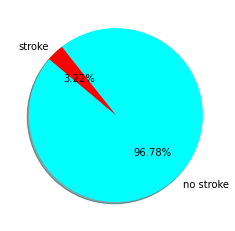

In [6]:
labels=['no stroke','stroke']
colors = ["cyan","red"]
plt.pie(df['stroke'].value_counts(),labels=labels,colors=colors,
        autopct='%1.2f%%', shadow=True, startangle=140) 
plt.show()

In [8]:
x = df.copy()
x = x.drop(columns='stroke')
y = df['stroke']
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(x, y)
x_train, x_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size= 0.2, random_state= 42)
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

6052
6052
1514
1514


## Running XGBoost

In [9]:
model = xgb.XGBClassifier() 
model.fit(x_train,y_train)


C:\Users\razor\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[20:42:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Based XGBoost Prediction

In [12]:
y_pred1 = model.predict(x_test)
print('Confusion Matrix :' ,confusion_matrix(y_test, y_pred1))
print('F1 Score: ',f1_score(y_test, y_pred1))

Confusion Matrix : [[759  12]
 [  7 736]]
F1 Score:  0.9872568745808181


## Grid Search XGBoost

In [17]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
xgb_gridsearch = xgb.XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)


In [18]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
folds = 5
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb_gridsearch, param_distributions=params, n_iter=param_comb, scoring='f1_micro', n_jobs=4,  verbose=3, random_state=1001 )
random_search.fit(x_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
C:\Users\razor\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[20:51:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:51:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=0.02,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=600, n_job...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                           scale_pos_weight=No

In [19]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)


 All results:
{'mean_fit_time': array([3.26039944, 5.2759306 , 4.865063  , 3.8413074 , 4.27278004]), 'std_fit_time': array([0.0448973 , 0.12954485, 0.14491217, 0.04844826, 0.39588743]), 'mean_score_time': array([0.01462827, 0.0305995 , 0.03119984, 0.02579961, 0.01856556]), 'std_score_time': array([0.00099507, 0.00145854, 0.00292685, 0.00149432, 0.00261401]), 'param_subsample': masked_array(data=[1.0, 0.6, 0.8, 1.0, 0.8],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[5, 1, 5, 5, 1],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[3, 5, 5, 5, 4],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=[5, 1.5, 1, 5, 1],
             mask=[False, False, False, False, False],
       fill_value='?',
            dt

## Generate submission

In [20]:
# from . import generate_submission
from generate_submission import generate_submission
test_df = pd.read_csv("./Dataset/processed_test.csv")
generate_submission(random_search, test_df, 'xgboost_gridsearch')

## Save Model

In [27]:
from model_utils import save_model, load_model
save_model(random_search, './models/xgb_gridsearch')